<a href="https://colab.research.google.com/github/akashpaira/Machine_Learning_projects/blob/master/Sentiment_Analysis_Tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis
![alt text](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/0cc39c70021d21fc0d2fd7a986ccd242bef86c29/6-Figure1-1.png)

In [2]:
import pandas as pd
import seaborn as sns

sns.set(rc={'figure.figsize':(30,1)})

def visualise_sentiments(data):
  sns.heatmap(pd.DataFrame(data).set_index("Sentence").T,center=0, annot=True, cmap = "PiYG")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
sentence = "i really like you but you can be so dumb some times"
sentence1 = "I love u"

## NLTK Vader

In [4]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [5]:
sid.polarity_scores(sentence)

{'compound': -0.7154, 'neg': 0.35, 'neu': 0.537, 'pos': 0.113}

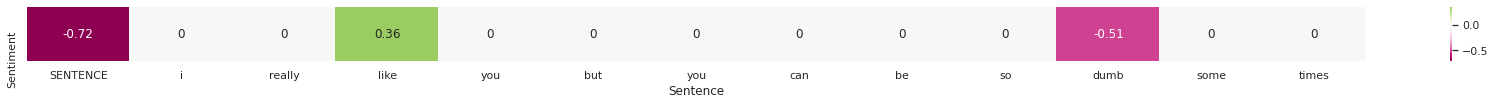

In [6]:
visualise_sentiments({
    "Sentence":["SENTENCE"] + sentence.split(),
    "Sentiment":[sid.polarity_scores(sentence)["compound"]] + [sid.polarity_scores(word)["compound"] for word in sentence.split()]
})

## TextBlob

In [7]:
from textblob import TextBlob

In [8]:
TextBlob(sentence).sentiment

Sentiment(polarity=-0.0875, subjectivity=0.35)

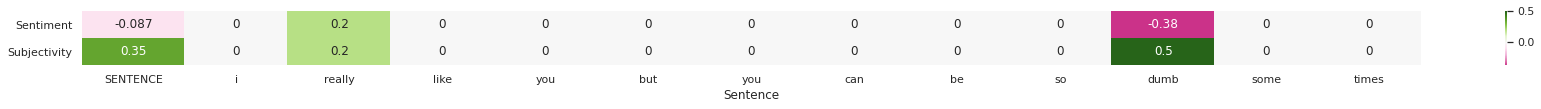

In [9]:
visualise_sentiments({
      "Sentence":["SENTENCE"] + sentence.split(),
      "Sentiment":[TextBlob(sentence).polarity] + [TextBlob(word).polarity for word in sentence.split()],
      "Subjectivity":[TextBlob(sentence).subjectivity] + [TextBlob(word).subjectivity for word in sentence.split()],
})

## Flair

In [ ]:
!pip3 install flair
import flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

In [11]:
s = flair.data.Sentence(sentence)
flair_sentiment.predict(s)
total_sentiment = s.labels
total_sentiment

[POSITIVE (0.9739)]

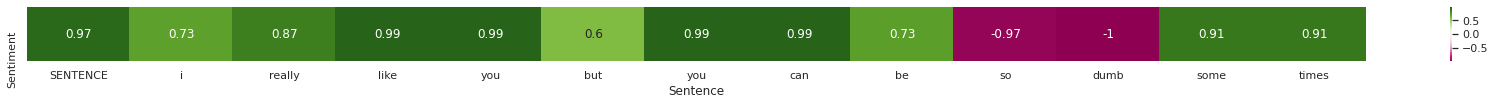

In [12]:
tokens = [token.text for token in s.tokens]
ss = [flair.data.Sentence(s) for s in tokens]
[flair_sentiment.predict(s) for s in ss]
sentiments = [s.labels[0].score * (-1,1)[str(s.labels[0]).split()[0].startswith("POS")] for s in ss]

visualise_sentiments({
      "Sentence":["SENTENCE"] + tokens,
      "Sentiment":[total_sentiment[0].score *(-1,1)[str(total_sentiment[0]).split()[0].startswith("POS")]] + sentiments,
})

## DeepMoji (Emotions via Emojis)

In [ ]:
!pip3 install torch==1.0.1 -f https://download.pytorch.org/whl/cpu/stable 
!git clone https://github.com/huggingface/torchMoji
import os
os.chdir('torchMoji')
!pip3 install -e .

type "yes" when prompted

In [ ]:
!python3 scripts/download_weights.py

In [15]:
!python3 examples/text_emojize.py --text f" {sentence1} "

/content/torchMoji/torchmoji/model_def.py:159: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(self.embed.weight.data, a=-0.5, b=0.5)
/content/torchMoji/torchmoji/model_def.py:161: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(t)
/content/torchMoji/torchmoji/model_def.py:163: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(t)
/content/torchMoji/torchmoji/model_def.py:165: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(t, 0)
/content/torchMoji/torchmoji/model_def.py:167: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.output_layer[0].weight.data)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.w

In [ ]:
import numpy as np
import emoji, json
from torchmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH
from torchmoji.sentence_tokenizer import SentenceTokenizer
from torchmoji.model_def import torchmoji_emojis
  
EMOJIS = ":joy: :unamused: :weary: :sob: :heart_eyes: :pensive: :ok_hand: :blush: :heart: :smirk: :grin: :notes: :flushed: :100: :sleeping: :relieved: :relaxed: :raised_hands: :two_hearts: :expressionless: :sweat_smile: :pray: :confused: :kissing_heart: :heartbeat: :neutral_face: :information_desk_person: :disappointed: :see_no_evil: :tired_face: :v: :sunglasses: :rage: :thumbsup: :cry: :sleepy: :yum: :triumph: :hand: :mask: :clap: :eyes: :gun: :persevere: :smiling_imp: :sweat: :broken_heart: :yellow_heart: :musical_note: :speak_no_evil: :wink: :skull: :confounded: :smile: :stuck_out_tongue_winking_eye: :angry: :no_good: :muscle: :facepunch: :purple_heart: :sparkling_heart: :blue_heart: :grimacing: :sparkles:".split(' ')
model = torchmoji_emojis(PRETRAINED_PATH)
with open(VOCAB_PATH, 'r') as f:
  vocabulary = json.load(f)
st = SentenceTokenizer(vocabulary, 30)

def deepmojify(sentence,top_n =5):
  def top_elements(array, k):
    ind = np.argpartition(array, -k)[-k:]
    return ind[np.argsort(array[ind])][::-1]

  tokenized, _, _ = st.tokenize_sentences([sentence])
  prob = model(tokenized)[0]
  emoji_ids = top_elements(prob, top_n)
  emojis = map(lambda x: EMOJIS[x], emoji_ids)
  return emoji.emojize(f"{sentence} {' '.join(emojis)}", use_aliases=True)

In [ ]:
deepmojify(sentence, top_n = 3)